In [1]:

# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
    

In [2]:

# Cell 2: Load the dataset
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
    

In [3]:

# Cell 3: Check the dataset
print("Training Data Shape: ", train_df.shape)
print("Testing Data Shape: ", test_df.shape)
train_df.head()
    

Training Data Shape:  (27455, 785)
Testing Data Shape:  (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:

# Cell 4: Separate features and labels
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values
    

In [5]:

# Cell 5: Adjust labels to be in range 0-23 (since we have 24 classes)
y_train = np.where(y_train > 8, y_train - 1, y_train)
y_test = np.where(y_test > 8, y_test - 1, y_test)
    

In [6]:

# Cell 6: Normalize the pixel values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    

In [7]:

# Cell 7: Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    

In [8]:

# Cell 8: Create DataLoader for training and testing
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

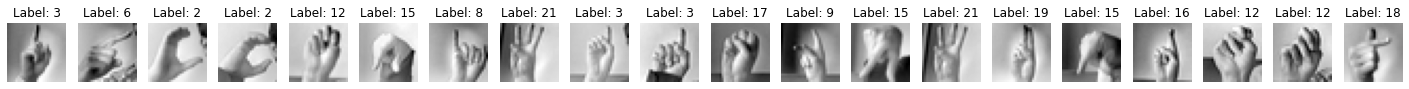

In [9]:

# Cell 9: Plot some sample images from the dataset
def plot_sample_images(X, y, n=20):
    plt.figure(figsize=(25, 25))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.show()

plot_sample_images(X_train, y_train)
    

In [10]:

# Cell 10: Define the ANN model
class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        self.layer1 = nn.Linear(784, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 24)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# Instantiate the model
model = ANN_Model()

In [11]:

# Cell 11: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
    

In [12]:

# Cell 12: Training the model with validation
epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Split the training set into training and validation sets
X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

train_dataset_part = TensorDataset(X_train_part, y_train_part)
valid_dataset_part = TensorDataset(X_valid_part, y_valid_part)

train_loader_part = DataLoader(train_dataset_part, batch_size=batch_size, shuffle=True)
valid_loader_part = DataLoader(valid_dataset_part, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader_part:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader_part)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader_part:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    valid_loss = running_loss / len(valid_loader_part)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}")
    

Epoch 1/10, Train Loss: 0.7829964240623075, Train Accuracy: 0.7546894918958296, Valid Loss: 0.08893077943993863, Valid Accuracy: 0.9763248952831907
Epoch 2/10, Train Loss: 0.11537188157265962, Train Accuracy: 0.96476051720998, Valid Loss: 0.03645001785006634, Valid Accuracy: 0.9899836095428883
Epoch 3/10, Train Loss: 0.060302825826765064, Train Accuracy: 0.982107084319796, Valid Loss: 0.017569004713698443, Valid Accuracy: 0.9938080495356038
Epoch 4/10, Train Loss: 0.06391942042818152, Train Accuracy: 0.9796485157530505, Valid Loss: 0.009598405721738154, Valid Accuracy: 0.9969040247678018
Epoch 5/10, Train Loss: 0.06468860461710962, Train Accuracy: 0.9805135676561646, Valid Loss: 0.017181370602947724, Valid Accuracy: 0.9943543981059916
Epoch 6/10, Train Loss: 0.04975161408862711, Train Accuracy: 0.9844745947914769, Valid Loss: 0.014443318448388181, Valid Accuracy: 0.9956292114368968
Epoch 7/10, Train Loss: 0.05581037057702836, Train Accuracy: 0.9828810781278455, Valid Loss: 0.0033503818

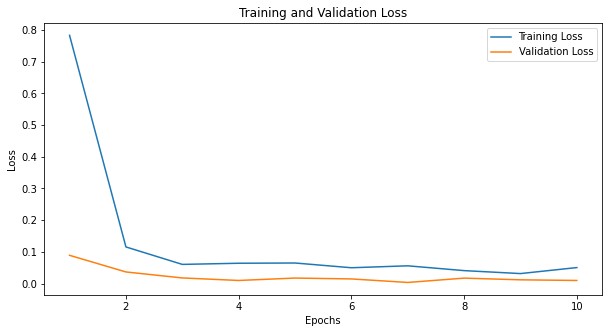

In [13]:

# Cell 13: Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
    

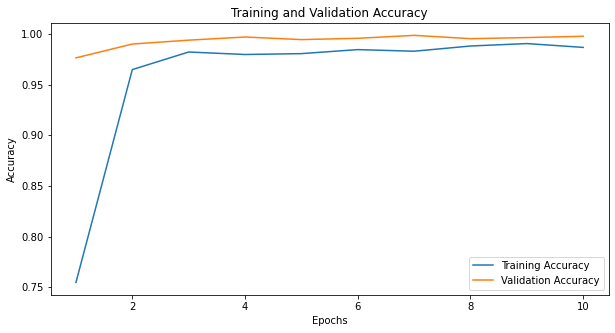

In [14]:

# Cell 14: Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
    

In [15]:

# Cell 15: Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())
    

In [16]:

# Cell 16: Calculate accuracy and F1-score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
    

Accuracy: 0.8232013385387619
F1 Score: 0.8213659506836226


In [17]:

# Cell 18: Display the classification report
class_report = classification_report(y_true, y_pred)
print(class_report)
    

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       331
           1       0.98      0.97      0.98       432
           2       0.96      0.97      0.97       310
           3       0.79      1.00      0.88       245
           4       0.91      0.95      0.93       498
           5       0.82      0.99      0.90       247
           6       0.93      0.80      0.86       348
           7       0.95      0.95      0.95       436
           8       0.74      0.71      0.73       288
           9       0.79      0.62      0.69       331
          10       0.86      1.00      0.93       209
          11       0.84      0.81      0.82       394
          12       0.82      0.53      0.64       291
          13       0.82      0.74      0.78       246
          14       1.00      1.00      1.00       347
          15       0.52      0.98      0.68       164
          16       0.46      0.65      0.54       144
          17       0.60    

In [18]:
torch.save(model.state_dict(), 'model.pth')